# Projects in AI/ML Final Project Notebook

## Cloning Project From GitHub Repository

To run the experiment, we need to clone the repository into the local Google Colab filesystem.

In [ ]:
!git clone --recurse-submodules https://github.com/aiden-dm/Unlearning-MIA-Eval.git

Cloning into 'Unlearning-MIA-Eval'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 248 (delta 47), reused 53 (delta 23), pack-reused 171 (from 2)
Receiving objects: 100% (248/248), 249.20 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Updating files: 100% (19/19), done.
Submodule 'Third_Party_Code/BadTeach' (https://github.com/aiden-dm/bad-teaching-unlearning) registered for path 'Third_Party_Code/BadTeach'
Submodule 'Third_Party_Code/SCRUB' (https://github.com/aiden-dm/SCRUB) registered for path 'Third_Party_Code/SCRUB'
Submodule 'Third_Party_Code/SSD' (https://github.com/aiden-dm/selective-synaptic-dampening) registered for path 'Third_Party_Code/SSD'
Cloning into '/content/Unlearning-MIA-Eval/Third_Party_Code/BadTeach'...
remote: Enumerating objects: 69, done.        
remote: Counting objects: 100% (69/69), done.        
remote: Compressing objects: 100% (64/64),

This can be used to delete the local copy of the repository, in the case it needs to be changed or re-cloned.

In [ ]:
!rm -rf /content/Unlearning-MIA-Eval

We also need to add the root repository file to the system path so that all dependencies can be found when running code.

In [ ]:
import sys

# Adding the local files to the system path
sys.path.append('/content/Unlearning-MIA-Eval/')

## Getting Data Loaders

The following code fetches all of the dataloaders that will be used. The dataset is CIFAR-10.

In [ ]:
from Final_Structure.datasets import get_loaders

# Getting all the loaders
root_path = '/content/Unlearning-MIA-Eval/Final_Structure/data'
forget_classes = [1]
loaders = get_loaders(root=root_path, forget_classes=forget_classes)

# Extracting the loaders we need
train_loader = loaders[0]
valid_loader = loaders[1]
test_loader = loaders[2]
train_forget_loader = loaders[3]
train_retain_loader = loaders[4]
valid_forget_loader = loaders[5]
valid_retain_loader = loaders[6]
test_forget_loader = loaders[7]
test_retain_loader = loaders[8]

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


## Training and Unlearning

### Training Full and Retain ResNet18 Models

The following code trains a ResNet18 model on two datasets:

1. Full train dataset
2. Retain dataset (the dataset that does not contain the classes we intend to forget)

In [ ]:
from types import SimpleNamespace
from Final_Structure.training import train_resnet

# Defining inputs
root = '/content/Unlearning-MIA-Eval/Final_Structure/data'
dataset = 'cifar10'
forget_classes = [1]
batch_size = 32

# Defining the args namespace
args = SimpleNamespace()

# Defining hyperparameters
args.learning_rate = 0.0001
args.epochs = 25
args.full_path = "/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_full.pt"
args.retain_path = "/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_retain.pt"

# Train the full and retain versions of the ResNet18 Model
train_resnet(root=root,
             dataset=dataset,
             forget_classes=forget_classes,
             batch_size=batch_size,
             args=args)

Files already downloaded and verified
Files already downloaded and verified
Training ResNet18 model on the full dataset...
Starting Epoch [1/15]...
Epoch [1/15], Loss: 1.5518, Accuracy: 0.4392
Starting Epoch [2/15]...
Epoch [2/15], Loss: 1.1919, Accuracy: 0.5766
Starting Epoch [3/15]...
Epoch [3/15], Loss: 0.9793, Accuracy: 0.6523
Starting Epoch [4/15]...
Epoch [4/15], Loss: 0.8168, Accuracy: 0.7137
Starting Epoch [5/15]...
Epoch [5/15], Loss: 0.6549, Accuracy: 0.7699
Starting Epoch [6/15]...
Epoch [6/15], Loss: 0.5202, Accuracy: 0.8163
Starting Epoch [7/15]...
Epoch [7/15], Loss: 0.3963, Accuracy: 0.8615
Starting Epoch [8/15]...
Epoch [8/15], Loss: 0.3091, Accuracy: 0.8923
Starting Epoch [9/15]...
Epoch [9/15], Loss: 0.2463, Accuracy: 0.9143
Starting Epoch [10/15]...
Epoch [10/15], Loss: 0.2167, Accuracy: 0.9244
Starting Epoch [11/15]...
Epoch [11/15], Loss: 0.1783, Accuracy: 0.9380
Starting Epoch [12/15]...
Epoch [12/15], Loss: 0.1679, Accuracy: 0.9416
Starting Epoch [13/15]...
Epoch

### Unlearning Helper Functions

The following function plots four lines on a single plot:

1. Training Retain Set Accuracy
2. Training Forget Set Accuracy
3. Validation Retain Set Accuracy
4. Validation Forget Set Accuracy

These accuracy metrics are collecting during each unlearning process and can be used to evaluate the effectiveness of the unlearning. Ideally, we want to see low accuracy for the forget sets and high accuracy on the retain sets. The validation set is used to gauge how well our model is generalizing.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def plot_history(history):
    plt.plot(history['epoch_list'], history['tr_accs'], marker='*', color=u'#1f77b4', alpha=1, label='retain-set')
    plt.plot(history['epoch_list'], history['tf_accs'], marker='o', color=u'#ff7f0e', alpha=1, label='forget-set')
    plt.plot(history['epoch_list'], history['vr_accs'], marker='^', color=u'#2ca02c',alpha=1, label='validation-set')
    plt.plot(history['epoch_list'], history['vf_accs'], marker='.', color='red',alpha=1, label='forget-validation-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.xlabel('epoch',size=14)
    plt.ylabel('accuracy (%)',size=14)
    plt.grid()
    plt.show()

### Performing SCRUB Unlearning

The following allows us to run the SCRUB unlearning algorithm with some modifiable hyperparameters.

In [ ]:
from types import SimpleNamespace

# Defining the args namespace
args = SimpleNamespace()

# Hyperparameters
args.epochs = 10
args.learning_rate = 0.0001
args.msteps = 5             # Unlearning is performed from epoch 0-msteps (inclusive)
args.t_opt_gamma = 1        # Weight for CE loss
args.t_opt_alpha = 0.5      # Weight for KL divergence
args.kd_T = 4               # KL divergence temperature
args.print_accuracies = True

In [ ]:
from Final_Structure.scrub import scrub
from Final_Structure.training import load_model

# Train the scrub unlearning model
full_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_full.pt'
scrub_model = load_model(full_path)
scrub_model, scrub_history = scrub(scrub_model, loaders, args)

Epoch 1: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 94.12222222222222
   tf_acc: 81.8
   vr_acc: 75.84019586022701
   vf_acc: 59.07297830374753
Epoch 2: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 82.8488888888889
   tf_acc: 0.0
   vr_acc: 72.27910082350323
   vf_acc: 0.0
Epoch 3: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 65.43777777777778
   tf_acc: 0.0
   vr_acc: 63.06476741598041
   vf_acc: 0.0
Epoch 4: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 55.05555555555556
   tf_acc: 0.0
   vr_acc: 54.284442466058316
   vf_acc: 0.0
Epoch 5: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 52.43333333333333
   tf_acc: 0.0
   vr_acc: 51.62474961050523
   vf_acc: 0.0
Epoch 6: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_acc: 62.724444444444444
   tf_acc: 0.0
   vr_acc: 61.21744936567995
   vf_acc: 0.0
Epoch 7: maximize loss: 0.00, minimize loss: 0.00, train_acc: 0
   tr_ac

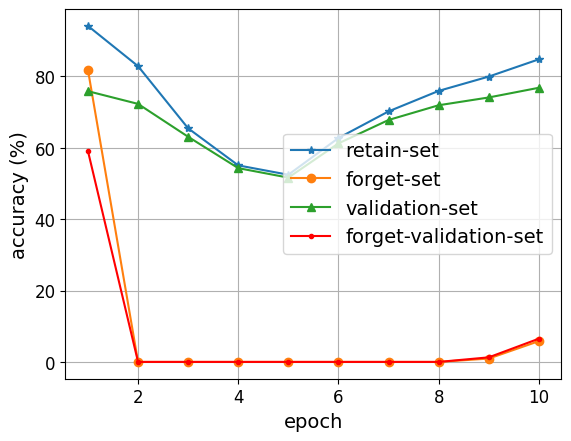

In [ ]:
plot_history(scrub_history)

### Performing Bad Teach Unlearning

The following allows us to run the Bad Teach unlearning algorithm with some modifiable hyperparameters.

In [ ]:
from types import SimpleNamespace

# Defining the args namespace
args = SimpleNamespace()

# Hyperparameters
args.epochs = 10
args.learning_rate = 0.0001
args.KL_temperature = 4
args.batch_size = 256
args.print_accuracies = True

In [ ]:
from Final_Structure.badt import badt
from Final_Structure.training import load_model

# Train the scrub unlearning model
full_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_full.pt'
badt_model, badt_history = badt(full_path, loaders, args)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1 Unlearning Loss 0.0032499798107892275
   tr_acc: 91.81555555555556
   tf_acc: 9.62
   vr_acc: 66.34765190296017
   vf_acc: 4.043392504930966
Epoch 2 Unlearning Loss 0.0017167420592159033
   tr_acc: 91.63777777777777
   tf_acc: 6.28
   vr_acc: 65.94702871132873
   vf_acc: 3.648915187376726
Epoch 3 Unlearning Loss 0.0010116840712726116
   tr_acc: 91.82
   tf_acc: 4.84
   vr_acc: 66.03605608724683
   vf_acc: 4.733727810650888
Epoch 4 Unlearning Loss 0.0006716671050526202
   tr_acc: 91.27333333333333
   tf_acc: 1.96
   vr_acc: 65.06788337413755
   vf_acc: 1.6765285996055226
Epoch 5 Unlearning Loss 0.0005030174506828189
   tr_acc: 91.58444444444444
   tf_acc: 0.94
   vr_acc: 65.04562653015802
   vf_acc: 1.0848126232741617
Epoch 6 Unlearning Loss 0.00040652358438819647
   tr_acc: 91.56444444444445
   tf_acc: 1.06
   vr_acc: 65.1680391720454
   vf_acc: 0.7889546351084813
Epoch 7 Unlearning Loss 0.0003624085511546582
   tr_acc: 91.58222222222223
   tf_acc: 0.28
   vr_acc: 65.2348097039

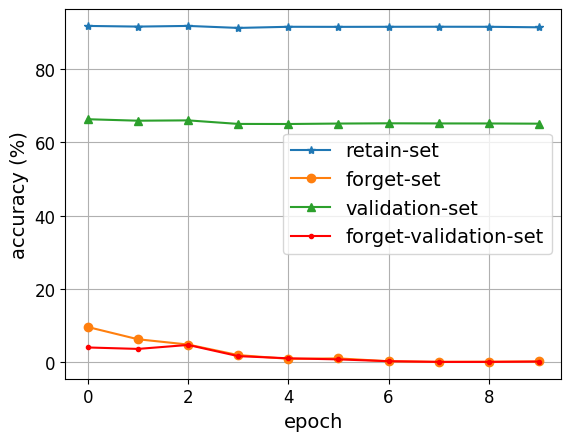

In [ ]:
plot_history(badt_history)

### Performing Selective Synaptic Dampening Unlearning

The following allows us to run the SSD unlearning algorithm with some modifiable hyperparameters.

In [ ]:
from types import SimpleNamespace

# Defining the args namespace
args = SimpleNamespace()

# Hyperparameters
args.learning_rate = 0.0001      # Doesn't impact unlearning
args.dampening_constant = 1      # Parameter used in the paper
args.selection_weighting = 10    # Parameter used in the paper

In [ ]:
from Final_Structure.ssd import ssd
from Final_Structure.training import load_model

# Train the scrub unlearning model
full_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_full.pt'
ssd_model, ssd_accs = ssd(full_path, loaders, args)

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 1, 'selection_weighting': 10}


In [ ]:
print(ssd_accs)

{'tr_acc': 77.84444444444445, 'tf_acc': 9.38, 'vr_acc': 55.67549521477854, 'vf_acc': 6.607495069033531}


## Writing Evaluation Code

### Evaluating Performance Post-Unlearning

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import argparse
import os
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

# Function that calculates a variety of evaluation metrics post unlearning
def evaluate_model(model, dataloader, device):
    # Putting model in evaluation mode
    model.eval()

    # Defining variables to store evaluation information
    all_preds = []
    all_labels = []
    losses = []
    criterion = nn.CrossEntropyLoss(reduction='none')

    # Evaluation loop
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            losses.append(criterion(outputs, labels).cpu())

    # Organizing predicted and true values
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Compute evaluation metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Full per-class report
    report = classification_report(y_true, y_pred, zero_division=0)

    # Preparing losses for return
    losses = torch.cat(losses)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'report': report,
        'losses': losses
    }

# Function for printing evaluation metrics
def print_metrics(metrics_dict, model_name, show_report=False, show_loss=False):
    print(f"\nMetrics for {model_name}:")
    for metric, value in metrics_dict.items():
        if metric == 'report':
            if show_report:
                print("\nPer-class classification report:\n")
                print(value)
            continue
        if metric == 'losses':
            if show_loss:
                print("\nLosses:")
                print(value)
            continue
        print(f"  {metric:10s}: {value:.4f}" if isinstance(value, float) else f"  {metric:10s}: {value}")

# Function for calculating and printing metrics
def calculate_and_print_metrics(
    model_list,
    name_list,
    dataloader,
    device,
    show_report=False,
    show_loss=False):
    for model, name in zip(model_list, name_list):
        metrics = evaluate_model(model, dataloader, device)
        print_metrics(metrics, name, show_report, show_loss)
        print()

### Membership Inference Attack

In [ ]:
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import confusion_matrix

def cm_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred)

    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[0][0]
    TN = cnf_matrix[1][1]

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    # Print information
    print(f"FPR:{FPR:.2f}, FNR:{FNR:.2f}, FP{FP:.2f}, TN{TN:.2f}, TP{TP:.2f}, FN{FN:.2f}")
    print(f"ACC: {ACC}")
    return ACC

def normalize_data(data):
    min_value = np.min(data)
    max_value = np.max(data)

    # Apply Min-Max normalization
    normalized_data = (data - min_value) / (max_value - min_value)
    return normalized_data

def evaluate_attack_model(sample_loss, members, n_splits = 5, random_state = None):
    unique_members = np.unique(members)
    attack_model = LogisticRegression()
    cv = StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state)
    return cross_val_score(attack_model, sample_loss, members, cv=cv, scoring=cm_score)

def membership_inference_attack(model, t_loader, f_loader, device, seed):

    # Initialization
    cr = nn.CrossEntropyLoss(reduction='none')
    test_losses = []
    forget_losses = []
    model.eval()

    # Calculating test losses
    for batch_idx, (data, target) in enumerate(t_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = cr(output, target)
        test_losses.extend(loss.cpu().detach().numpy())

    # Calculating forget losses
    for batch_idx, (data, target) in enumerate(f_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = cr(output, target)
        forget_losses.extend(loss.cpu().detach().numpy())

    # Ensuring test and forget losses are same length
    if len(forget_losses) > len(test_losses):
        forget_losses = list(random.sample(forget_losses, len(test_losses)))
    elif len(test_losses) > len(forget_losses):
        test_losses = list(random.sample(test_losses, len(forget_losses)))

    # Printing distributions of normalized test and forget losses
    min_loss = min(np.min(test_losses), np.min(forget_losses))
    max_loss = max(np.max(test_losses), np.max(forget_losses))
    bins = np.linspace(min_loss, max_loss, 30)
    fig, ax = plt.subplots()
    sns.histplot(test_losses, kde=False, label='Normalized test-loss', ax=ax, bins=bins)
    sns.histplot(forget_losses, kde=False, label='Normalized forget-loss', ax=ax, bins=bins)
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title("Normalized Loss Histograms", size=10)
    plt.xlabel('Normalized Loss Values', size=8)
    plt.show()


    # Preparing data for evaluation
    test_labels = [0]*len(test_losses)
    forget_labels = [1]*len(forget_losses)
    features = np.array(test_losses + forget_losses).reshape(-1,1)
    labels = np.array(test_labels + forget_labels).reshape(-1)
    features = np.clip(features, -100, 100)
    score = evaluate_attack_model(features, labels, n_splits=5, random_state=seed)

    return score

## Validation Performance

### Loading unlearned models

In [ ]:
from Final_Structure.training import load_model

# Defining checkpoint paths
scrub_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/scrub_applied.pt'
badt_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/badt_applied.pt'
ssd_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/ssd_applied.pt'
retain_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_retain.pt'

In [ ]:
scrub_model = load_model(scrub_path)

In [ ]:
badt_model = load_model(badt_path)

In [ ]:
ssd_model = load_model(ssd_path)

In [ ]:
retain_model = load_model(retain_path)

### Post-Learning Performance on Retained Data

In [ ]:
name_list = ['SCRUB', 'Bad Teach', 'SSD', 'Retain']
model_list = [scrub_model, badt_model, ssd_model, retain_model]
calculate_and_print_metrics(model_list, name_list, valid_retain_loader, 'cuda', show_report=False, show_loss=False)


Metrics for SCRUB:
  accuracy  : 0.7680
  precision : 0.6943
  recall    : 0.6908
  f1        : 0.6914


Metrics for Bad Teach:
  accuracy  : 0.6513
  precision : 0.6028
  recall    : 0.5862
  f1        : 0.5928


Metrics for SSD:
  accuracy  : 0.5568
  precision : 0.5846
  recall    : 0.5022
  f1        : 0.5114


Metrics for Retain:
  accuracy  : 0.9819
  precision : 0.9822
  recall    : 0.9817
  f1        : 0.9819



### Post-Learning Performance on Forgotten Data

In [ ]:
name_list = ['SCRUB', 'Bad Teach', 'SSD', 'Retain']
model_list = [scrub_model, badt_model, ssd_model, retain_model]
calculate_and_print_metrics(model_list, name_list, valid_forget_loader, 'cuda', show_report=False, show_loss=False)


Metrics for SCRUB:
  accuracy  : 0.0651
  precision : 0.1000
  recall    : 0.0065
  f1        : 0.0122


Metrics for Bad Teach:
  accuracy  : 0.0020
  precision : 0.1000
  recall    : 0.0002
  f1        : 0.0004


Metrics for SSD:
  accuracy  : 0.0661
  precision : 0.1000
  recall    : 0.0066
  f1        : 0.0124


Metrics for Retain:
  accuracy  : 0.0000
  precision : 0.0000
  recall    : 0.0000
  f1        : 0.0000



### Membership Inference Attack Performance

In [ ]:
full_path = '/content/Unlearning-MIA-Eval/Final_Structure/checkpoints/resnet_full.pt'
full_model = load_model(full_path)
SEED = 42
DEVICE = 'cuda'

#### Fully Retrained Model

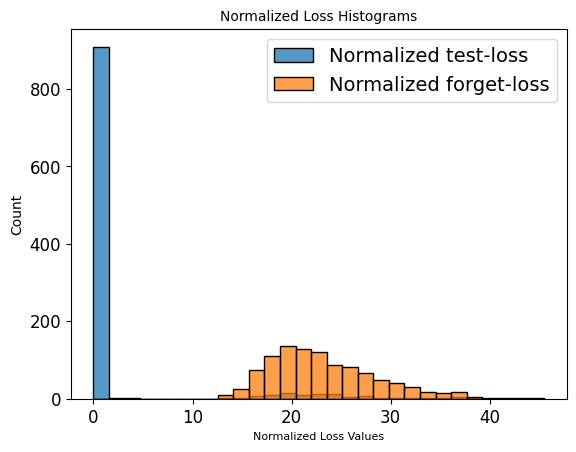

FPR:0.09, FNR:0.00, FP10.00, TN101.00, TP92.00, FN0.00
ACC: 0.9507389162561576
FPR:0.10, FNR:0.01, FP11.00, TN101.00, TP90.00, FN1.00
ACC: 0.9408866995073891
FPR:0.09, FNR:0.00, FP10.00, TN101.00, TP92.00, FN0.00
ACC: 0.9507389162561576
FPR:0.08, FNR:0.00, FP9.00, TN102.00, TP92.00, FN0.00
ACC: 0.9556650246305419
FPR:0.08, FNR:0.01, FP9.00, TN100.00, TP93.00, FN1.00
ACC: 0.9507389162561576


In [ ]:
# Example function call for the model before unlearning
score_before = membership_inference_attack(
    retain_model,
    valid_loader,
    valid_forget_loader,
    device=DEVICE,
    seed=SEED
)

#### SCRUB

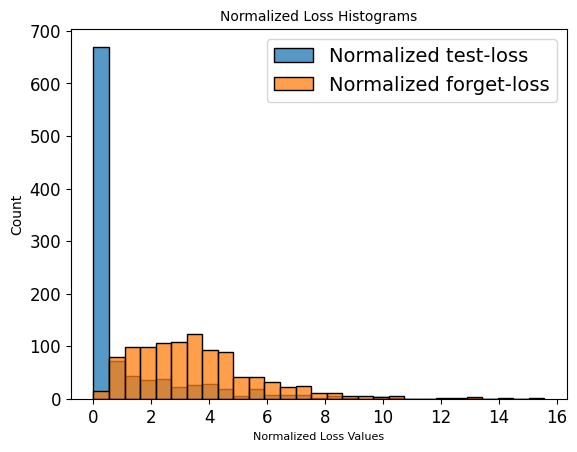

FPR:0.21, FNR:0.19, FP22.00, TN82.00, TP80.00, FN19.00
ACC: 0.7980295566502463
FPR:0.12, FNR:0.20, FP11.00, TN79.00, TP90.00, FN23.00
ACC: 0.8325123152709359
FPR:0.18, FNR:0.22, FP17.00, TN77.00, TP85.00, FN24.00
ACC: 0.7980295566502463
FPR:0.12, FNR:0.26, FP10.00, TN70.00, TP91.00, FN32.00
ACC: 0.7931034482758621
FPR:0.27, FNR:0.30, FP25.00, TN68.00, TP77.00, FN33.00
ACC: 0.7142857142857143


In [ ]:
# Example function call for the model after unlearning
score_scrub = membership_inference_attack(
    scrub_model,
    valid_loader,
    valid_forget_loader,
    device=DEVICE,
    seed=SEED
)

#### Bad Teach

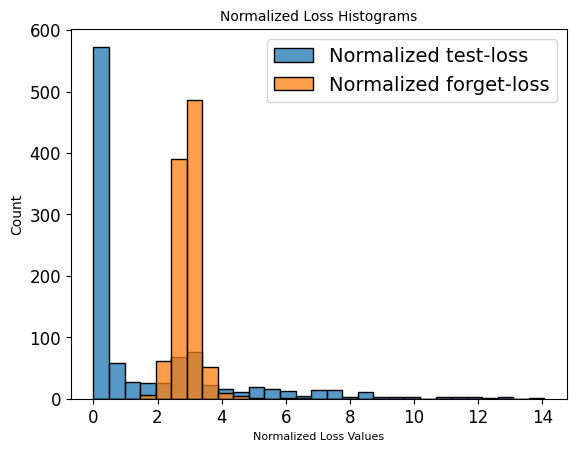

FPR:0.25, FNR:0.01, FP34.00, TN100.00, TP68.00, FN1.00
ACC: 0.8275862068965517
FPR:0.21, FNR:0.03, FP27.00, TN100.00, TP74.00, FN2.00
ACC: 0.8571428571428571
FPR:0.27, FNR:0.04, FP36.00, TN98.00, TP66.00, FN3.00
ACC: 0.8078817733990148
FPR:0.21, FNR:0.05, FP26.00, TN98.00, TP75.00, FN4.00
ACC: 0.8522167487684729
FPR:0.21, FNR:0.01, FP26.00, TN100.00, TP76.00, FN1.00
ACC: 0.8669950738916257


In [ ]:
# Example function call for the model after unlearning
score_badt = membership_inference_attack(
    badt_model,
    valid_loader,
    valid_forget_loader,
    device=DEVICE,
    seed=SEED
)

#### SSD

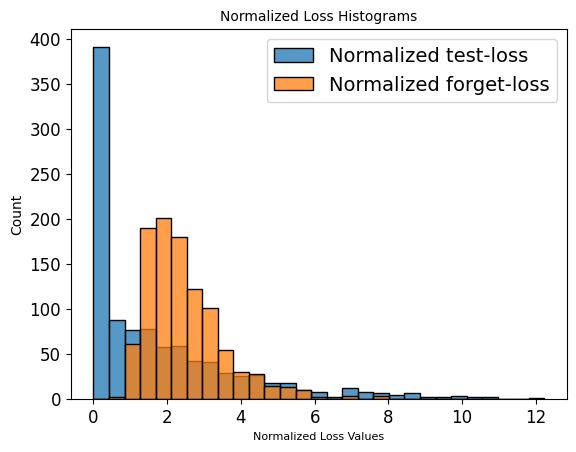

FPR:0.35, FNR:0.39, FP28.00, TN53.00, TP74.00, FN48.00
ACC: 0.625615763546798
FPR:0.43, FNR:0.45, FP36.00, TN48.00, TP65.00, FN54.00
ACC: 0.5566502463054187
FPR:0.34, FNR:0.36, FP32.00, TN61.00, TP70.00, FN40.00
ACC: 0.645320197044335
FPR:0.32, FNR:0.39, FP25.00, TN54.00, TP76.00, FN48.00
ACC: 0.6403940886699507
FPR:0.36, FNR:0.41, FP28.00, TN50.00, TP74.00, FN51.00
ACC: 0.6108374384236454


In [ ]:
# Example function call for the model after unlearning
score_ssd = membership_inference_attack(
    ssd_model,
    valid_loader,
    valid_forget_loader,
    device=DEVICE,
    seed=SEED
)